
# Bipartite ER and  Analysis (just one)

In [ ]:
import numpy as np
import pandas as pd
# for june: if you install this u need a newer version for the girth (NetworkX >= 3.2)
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms.bipartite.generators import random_graph as bipartite_random_graph
from networkx.linalg.algebraicconnectivity import algebraic_connectivity, fiedler_vector
from networkx.algorithms.cycles import girth as nx_girth 


Sources:
https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.bipartite.generators.random_graph.html

In [1]:
# Parameters 
n_qubits = 9   # size of Q
n_checks = 4   # size of C
p = 0.8        # edge probability for Q<->C edges
seed = 42      # RNG seed

# Result paths
OUT_DIR = "outputs"
BIADJ_CSV = f"{OUT_DIR}/biadjacency_QxC.csv"
DEGREE_CSV = f"{OUT_DIR}/degrees.csv"


In [3]:
# Build bipartite sets
Q = [f"q{i}" for i in range(n_qubits)]
C = [f"c{j}" for j in range(n_checks)]

# Generate bipartite ER graph (edges only between Q and C)
G = bipartite_random_graph(n_qubits, n_checks, p, seed=seed)

# Re-label nodes to clear numeric -> 'qX'/'cY'
# By default, NetworkX creates two partitions indexed 0..n_qubits-1 and 0..n_checks-1 in a single namespace.
# map them to Q and C labels to make analysis clearer.
mapping = {}
# Left partition are 0..n_qubits-1 with bipartite=0
left_nodes = [n for n, d in G.nodes(data=True) if d.get("bipartite", -1) == 0]
right_nodes = [n for n, d in G.nodes(data=True) if d.get("bipartite", -1) == 1]

# Sort to produce stable mapping
left_nodes_sorted = sorted(left_nodes)
right_nodes_sorted = sorted(right_nodes)

for i, n in enumerate(left_nodes_sorted):
    mapping[n] = Q[i]
for j, n in enumerate(right_nodes_sorted):
    mapping[n] = C[j]

G = nx.relabel_nodes(G, mapping, copy=True)

print(f"Nodes: {G.number_of_nodes()} (|Q|={len(Q)}, |C|={len(C)})")
print(f"Edges: {G.number_of_edges()}")
print("Logical qubits (if later interpreted as checks):", len(Q) - len(C))


Nodes: 13 (|Q|=9, |C|=4)
Edges: 30
Logical qubits (if later interpreted as checks): 5


In [4]:
# Degree stats
degQ = [G.degree(q) for q in Q]
degC = [G.degree(c) for c in C]
print("Q degrees:", degQ)
print("C degrees:", degC)
print("Average deg(Q):", np.mean(degQ), " | Average deg(C):", np.mean(degC))

# Algebraic connectivity (Fiedler value)
lam2 = float(algebraic_connectivity(G))
print("Fiedler (algebraic connectivity) λ2:", lam2)

# Fiedler vector 
fv = fiedler_vector(G)
print("First 5 entries of Fiedler vector:", np.asarray(fv)[:5])

# Girth
g = nx_girth(G)
print("Girth:", g)

# Save degrees to CSV
import os
os.makedirs(OUT_DIR, exist_ok=True)
deg_df = pd.DataFrame({
    "node": Q + C,
    "partition": ["Q"] * len(Q) + ["C"] * len(C),
    "degree": degQ + degC,
})
deg_df.to_csv(DEGREE_CSV, index=False)
DEGREE_CSV


Q degrees: [4, 3, 4, 4, 3, 3, 3, 4, 2]
C degrees: [8, 9, 7, 6]
Average deg(Q): 3.3333333333333335  | Average deg(C): 7.5
Fiedler (algebraic connectivity) λ2: 1.834635002147481
First 5 entries of Fiedler vector: [-0.07336439 -0.24366844 -0.07336439 -0.07336439  0.02453181]
Girth: 4


'outputs/degrees.csv'

In [5]:
# Build biadjacency matrix B with rows=Q, cols=C
B = np.zeros((len(Q), len(C)), dtype=int)
for u, v in G.edges():
    if u in Q and v in C:
        B[Q.index(u), C.index(v)] = 1
    elif v in Q and u in C:
        B[Q.index(v), C.index(u)] = 1

print("B shape:", B.shape)
print(B)

# Save to CSV
pd.DataFrame(B, index=Q, columns=C).to_csv(BIADJ_CSV)
BIADJ_CSV


B shape: (9, 4)
[[1 1 1 1]
 [1 1 0 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 0]
 [1 1 0 1]
 [1 1 1 0]
 [1 1 1 1]
 [0 1 1 0]]


'outputs/biadjacency_QxC.csv'

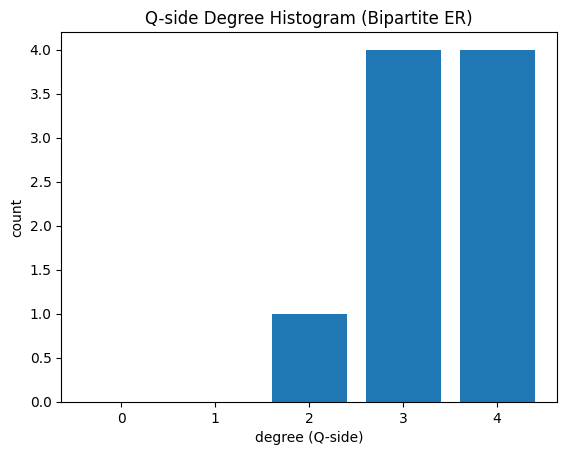

In [6]:
# Degree histogram for Q (qubits)
plt.figure()
plt.hist(degQ, bins=range(0, max(degQ + [1]) + 2), align="left", rwidth=0.8)
plt.xlabel("degree (Q-side)")
plt.ylabel("count")
plt.title("Q-side Degree Histogram (Bipartite ER)")
plt.show()
